In [ ]:
!pip install git+https://www.github.com/mouseland/cellpose.git

  Cloning https://www.github.com/mouseland/cellpose.git to /tmp/pip-req-build-tfq_fsxv
  Running command git clone --filter=blob:none --quiet https://www.github.com/mouseland/cellpose.git /tmp/pip-req-build-tfq_fsxv
  Resolved https://www.github.com/mouseland/cellpose.git to commit 17fb25f40055ec2636aa708dc4cf6625b8b4735d
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 95.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 106.9 MB/s eta 0:00:00
  Created wheel for cellpose: filename=cellpose-4.0.8-py3-none-any.whl size=212051 sha256=edd5d9653eb438ec08d8f4f79189b130db24eddaa05e63ff050b1067ce9408d0
  Stored in directory: /tmp/pip-ephem-wheel-cache-q22s5a35/wheels/df/b6/31/a3013c44290eabb46f4c06d1efb19744124fcad2d59684ec5e
Successfully built cellpose


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import tifffile as tiff
from pathlib import Path
import matplotlib.pyplot as plt
from skimage.segmentation import find_boundaries
from matplotlib.colors import ListedColormap
from skimage.measure import regionprops
import matplotlib.patheffects as pe

from cellpose import models


# =========================
# Tool: Standardize stack dimensions to (T, H, W)
# =========================
def ensure_THW(stack: np.ndarray, force_time_axis=None):
    """
    Input: (T,H,W) / (H,W,T) / (H,W)
    Output: (T,H,W)
    force_time_axis: None (auto) / 0 (force T at axis 0) / 2 (force T at axis 2)
    """
    if stack.ndim == 2:
        return stack[None, ...]  # Convert (H,W) to (1,H,W)

    if stack.ndim != 3:
        raise ValueError(f"Expected 2D/3D TIFF, but read ndim={stack.ndim}, shape={stack.shape}")

    if force_time_axis is not None:
        if force_time_axis == 0:
            return stack
        if force_time_axis == 2:
            return np.transpose(stack, (2, 0, 1))
        raise ValueError("force_time_axis must be None, 0, or 2")

    # Auto-heuristic: T (time) is usually significantly smaller than H or W
    s0, s1, s2 = stack.shape
    if s2 < s0 and s2 < s1:
        return np.transpose(stack, (2, 0, 1))  # (H,W,T) -> (T,H,W)

    return stack  # Default is already (T,H,W)


# =========================
# Tool: Pick the best frame for segmentation
# =========================
def pick_best_frame(stack_THW: np.ndarray, method="p99_minus_p50", p_hi=99, p_mid=50):
    """
    Selects the frame with the highest signal quality.
    method: "p99" / "mean" / "std" / "p99_minus_p50"
    """
    T = stack_THW.shape[0]
    flat = stack_THW.reshape(T, -1)

    if method == "p99":
        score = np.percentile(flat, p_hi, axis=1)
    elif method == "mean":
        score = flat.mean(axis=1)
    elif method == "std":
        score = flat.std(axis=1)
    elif method == "p99_minus_p50":
        # Signal (High percentile) minus Background (Median)
        score = np.percentile(flat, p_hi, axis=1) - np.percentile(flat, p_mid, axis=1)
    else:
        raise ValueError(f"Unknown frame score method: {method}")

    best_idx = int(np.argmax(score))
    return best_idx, stack_THW[best_idx], float(score[best_idx])


# =========================
# Tool: Save two-panel PNG (Raw vs Overlay) + ROI Labels
# =========================
def save_overlay_png_two_panel(best_frame, masks, out_png,
                               fill_alpha=0.35,
                               boundary_color="#ff69b4",
                               boundary_alpha=1.0,
                               suptitle=None,
                               show_overlay=False,
                               annotate_roi_id=False,
                               annotate_min_area=0,
                               annotate_max_rois=None,
                               annotate_fontsize=7):
    """
    Saves a comparison image: Left side is raw, Right side is the segmentation overlay.
    """
    out_png = Path(out_png)
    out_png.parent.mkdir(parents=True, exist_ok=True)

    # Generate 1px boundaries
    bnd = find_boundaries(masks, mode="outer")
    boundary_cmap = ListedColormap([boundary_color])

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Left: Raw frame
    axes[0].imshow(best_frame, cmap="gray", interpolation="nearest")
    axes[0].axis("off")

    # Right: Overlay
    axes[1].imshow(best_frame, cmap="gray", interpolation="nearest")

    # Mask fill
    m = np.ma.masked_where(masks == 0, masks)
    axes[1].imshow(m, alpha=fill_alpha, interpolation="nearest")

    # Boundary lines
    axes[1].imshow(np.ma.masked_where(~bnd, bnd),
                    cmap=boundary_cmap, alpha=boundary_alpha,
                    interpolation="nearest")

    # ROI ID Annotation
    if annotate_roi_id:
        props = sorted(regionprops(masks), key=lambda r: r.area, reverse=True)
        n_labeled = 0
        for r in props:
            if r.label == 0 or r.area < annotate_min_area:
                continue
            cy, cx = r.centroid
            txt = axes[1].text(
                cx, cy, str(r.label),
                color="white", fontsize=annotate_fontsize,
                ha="center", va="center"
            )
            # Add stroke for readability against background
            txt.set_path_effects([pe.withStroke(linewidth=2, foreground="black")])
            n_labeled += 1
            if annotate_max_rois is not None and n_labeled >= annotate_max_rois:
                break

    axes[1].axis("off")

    if suptitle:
        fig.suptitle(suptitle)

    plt.tight_layout()
    plt.savefig(out_png, dpi=200, bbox_inches="tight")
    if show_overlay:
        plt.show()
    plt.close(fig)


# =========================
# Tool: Extract ROI traces from full TIFF stack
# =========================
def extract_roi_traces_from_stack(stack_THW: np.ndarray,
                                  masks_HW: np.ndarray,
                                  statistic: str = "mean"):
    """
    Extracts intensity values over time for each ROI.
    stack_THW: (T,H,W) Input image stack
    masks_HW:  (H,W) Label mask (0=bg, 1..N=ROI id)
    statistic: "mean" or "sum"
    Returns: pandas.DataFrame (Rows=frames, Columns=ROI_1..ROI_N)
    """
    if stack_THW.ndim != 3:
        raise ValueError(f"stack_THW must be (T,H,W), got {stack_THW.shape}")
    if masks_HW.ndim != 2:
        raise ValueError(f"masks must be (H,W), got {masks_HW.shape}")
    if stack_THW.shape[1:] != masks_HW.shape:
        raise ValueError(f"Frame dimensions {stack_THW.shape[1:]} do not match mask {masks_HW.shape}")

    T = stack_THW.shape[0]
    flat_mask = masks_HW.ravel().astype(np.int32)
    n_labels = int(flat_mask.max())

    if n_labels == 0:
        raise ValueError("No ROIs found in masks (max label=0)")

    valid = flat_mask > 0
    labels = flat_mask[valid]
    counts = np.bincount(labels, minlength=n_labels + 1).astype(np.float64)
    counts[counts == 0] = np.nan  # Prevent division by zero

    traces = np.empty((T, n_labels), dtype=np.float32)

    for t in range(T):
        vals = stack_THW[t].ravel()[valid].astype(np.float64)
        sums = np.bincount(labels, weights=vals, minlength=n_labels + 1).astype(np.float64)
        if statistic == "mean":
            roi_vals = sums[1:] / counts[1:]
        elif statistic == "sum":
            roi_vals = sums[1:]
        else:
            raise ValueError("statistic must be 'mean' or 'sum'")
        traces[t, :] = roi_vals.astype(np.float32)

    import pandas as pd
    df = pd.DataFrame(traces, columns=[f"ROI_{i}" for i in range(1, n_labels + 1)])
    df.index.name = "frame"
    return df


# =========================
# Single TIFF Processing: Segment + Save results
# =========================
def segment_one_tiff(tiff_path, model, mask_dir, overlay_dir, params, force_time_axis=None):
    """
    Segments a single file, saves masks, visualization, and signal traces.
    """
    tiff_path = Path(tiff_path)
    mask_dir = Path(mask_dir); mask_dir.mkdir(parents=True, exist_ok=True)
    overlay_dir = Path(overlay_dir); overlay_dir.mkdir(parents=True, exist_ok=True)

    # Read and standardize dimensions
    stack = tiff.imread(str(tiff_path))
    stack_THW = ensure_THW(stack, force_time_axis=force_time_axis)

    # Select best frame for mask generation
    best_idx, best_frame, best_score = pick_best_frame(
        stack_THW,
        method=params["frame_score"],
        p_hi=params.get("percentile_hi", 99),
        p_mid=params.get("percentile_mid", 50),
    )

    # Prepare model arguments
    eval_kwargs = dict(
        channels=params.get("channels", [0, 0]),
        diameter=params.get("diameter", None),
        flow_threshold=params.get("flow_threshold", 0.4),
        cellprob_threshold=params.get("cellprob_threshold", 0.0),
        batch_size=params.get("batch_size", 8),
        normalize=params.get("normalize", True),
    )
    for k in ["min_size", "resample", "stitch_threshold"]:
        if k in params:
            eval_kwargs[k] = params[k]

    # Run Cellpose segmentation
    try:
        masks, flows, styles = model.eval(best_frame, **eval_kwargs)
    except TypeError:
        # Fallback for different Cellpose versions
        masks, flows, styles = model.eval(
            best_frame,
            channels=eval_kwargs["channels"],
            diameter=eval_kwargs["diameter"],
            flow_threshold=eval_kwargs["flow_threshold"],
            cellprob_threshold=eval_kwargs["cellprob_threshold"],
        )

    n_cells = int(masks.max())

    # Save Mask as TIFF
    out_mask = mask_dir / f"{tiff_path.stem}_masks.tif"
    tiff.imwrite(str(out_mask), masks.astype(np.uint16))

    # Save Overlay visualization
    out_png = overlay_dir / f"{tiff_path.stem}_bestFrame{best_idx}_overlay.png"
    if params.get("save_overlay", True):
        title = f"{tiff_path.name} | frame={best_idx} | cells={n_cells}"
        save_overlay_png_two_panel(
            best_frame, masks, out_png,
            fill_alpha=params.get("fill_alpha", 0.35),
            boundary_color=params.get("boundary_color", "white"),
            boundary_alpha=params.get("boundary_alpha", 1.0),
            suptitle=title,
            show_overlay=params.get("show_overlay", False),
            annotate_roi_id=params.get("annotate_roi_id", False),
            annotate_min_area=params.get("annotate_min_area", 0),
            annotate_max_rois=params.get("annotate_max_rois", None),
            annotate_fontsize=params.get("annotate_fontsize", 7),
        )

    # Extract signal traces
    trace_path = ""
    if params.get("extract_traces", False):
        trace_dir = Path(params.get("trace_dir", overlay_dir / "traces"))
        trace_dir.mkdir(parents=True, exist_ok=True)
        trace_path = trace_dir / f"{tiff_path.stem}_traces.csv"

        df_traces = extract_roi_traces_from_stack(
            stack_THW=stack_THW,
            masks_HW=masks,
            statistic=params.get("trace_statistic", "mean"),
        )
        df_traces.to_csv(trace_path)

    return {
        "file": tiff_path.name,
        "path": str(tiff_path),
        "raw_shape": tuple(stack.shape),
        "used_shape_THW": tuple(stack_THW.shape),
        "best_frame": best_idx,
        "frame_score": best_score,
        "n_cells": n_cells,
        "mask_path": str(out_mask),
        "overlay_path": str(out_png),
        "trace_path": str(trace_path) if trace_path else "",
    }


# =========================
# Batch Folder Processing
# =========================
def batch_segment_folder(input_dir, mask_dir, overlay_dir, params,
                         pattern="*.tif", force_time_axis=None,
                         save_csv=True, csv_path=None):
    """
    Iterates through a folder and processes all matching TIFF files.
    """
    input_dir = Path(input_dir)
    mask_dir = Path(mask_dir); mask_dir.mkdir(parents=True, exist_ok=True)
    overlay_dir = Path(overlay_dir); overlay_dir.mkdir(parents=True, exist_ok=True)

    # Initialize model (GPU recommended)
    model = models.CellposeModel(gpu=True)

    files = sorted(input_dir.glob(pattern))
    if not files:
        raise FileNotFoundError(f"No TIFF files matching {pattern} found in {input_dir}")

    results = []
    for f in files:
        try:
            res = segment_one_tiff(
                f, model=model,
                mask_dir=mask_dir,
                overlay_dir=overlay_dir,
                params=params,
                force_time_axis=force_time_axis
            )
            results.append(res)
            print(f"[OK] {res['file']} | frame={res['best_frame']} | cells={res['n_cells']}")
        except Exception as e:
            print(f"[FAIL] {f.name} -> {e}")
            results.append({"file": f.name, "path": str(f), "error": str(e)})

    # Save summary log
    if save_csv:
        import pandas as pd
        if csv_path is None:
            csv_path = overlay_dir / "segmentation_summary.csv"
        else:
            csv_path = Path(csv_path)
        pd.DataFrame(results).to_csv(csv_path, index=False)
        print("Saved summary:", str(csv_path))

    return results


# =========================
# Main: Entry Point
# =========================
def main():
    # === Configuration: Modify paths and parameters here ===
    params = {
        # Best frame selection logic
        "frame_score": "p99_minus_p50",
        "percentile_hi": 99,
        "percentile_mid": 50,

        # Cellpose parameters
        "channels": [0, 0],
        "diameter": None,
        "flow_threshold": 0.4,
        "cellprob_threshold": 0.0,
        "batch_size": 8,

        "normalize": {
            "percentile": (1, 99),
            "invert": False,
            "tile_norm_blocksize": 0,
            "sharpen_radius": 0,
            "smooth_radius": 0,
            "norm3D": False
        },

        "min_size": 15,
        "resample": True,

        # Visualization settings
        "save_overlay": True,
        "show_overlay": True,      # Set to False for large batch runs
        "fill_alpha": 0.5,
        "boundary_color": "white",
        "boundary_alpha": 1.0,

        "annotate_roi_id": True,
        "annotate_min_area": 50,
        "annotate_max_rois": None,
        "annotate_fontsize": 4,

        # Trace extraction settings
        "extract_traces": True,
        "trace_dir": "/content/drive/MyDrive/Colab Notebooks/Cellpose-SAM/traces/",
        "trace_statistic": "mean",   # Options: "mean" or "sum"
    }

    # Path settings
    input_dir   = "/content/drive/MyDrive/Colab Notebooks/Cellpose-SAM/BS50"
    mask_dir    = "/content/drive/MyDrive/Colab Notebooks/Cellpose-SAM/masks/"
    overlay_dir = "/content/drive/MyDrive/Colab Notebooks/Cellpose-SAM/overlay/"

    # Execution
    results = batch_segment_folder(
        input_dir=input_dir,
        mask_dir=mask_dir,
        overlay_dir=overlay_dir,
        params=params,
        pattern="*.tif",         # or "*.tiff"
        force_time_axis=None,    # Set to 2 if (H,W,T); Set to 0 if (T,H,W); None for auto
        save_csv=True
    )
    return results

if __name__ == "__main__":
    main()

100%|██████████| 1.15G/1.15G [00:03<00:00, 368MB/s]


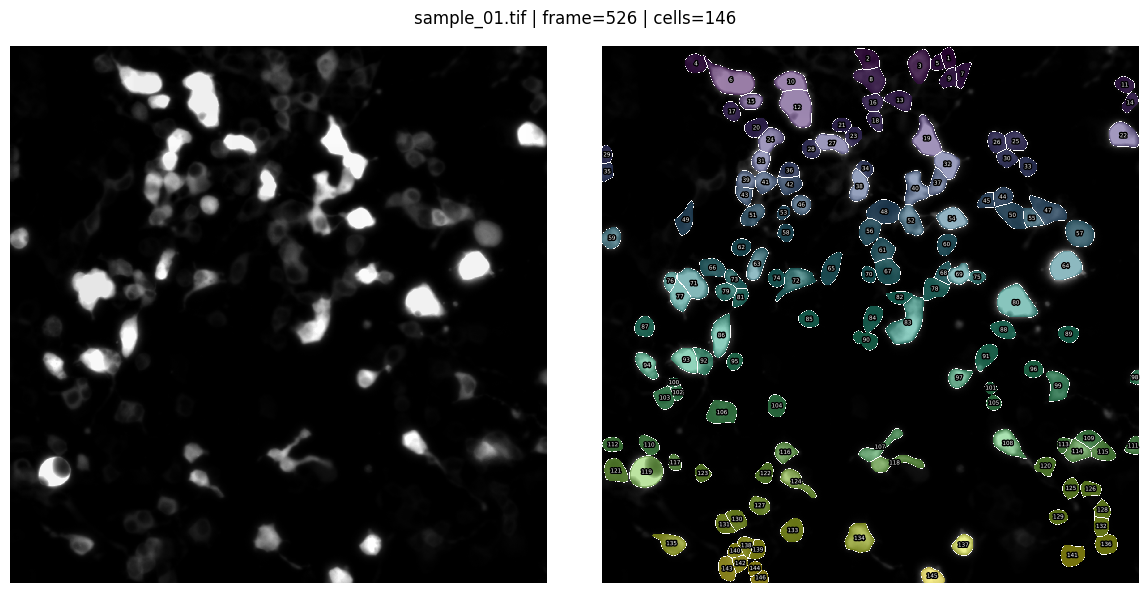

[OK] sample_01.tif | frame=526 | cells=146


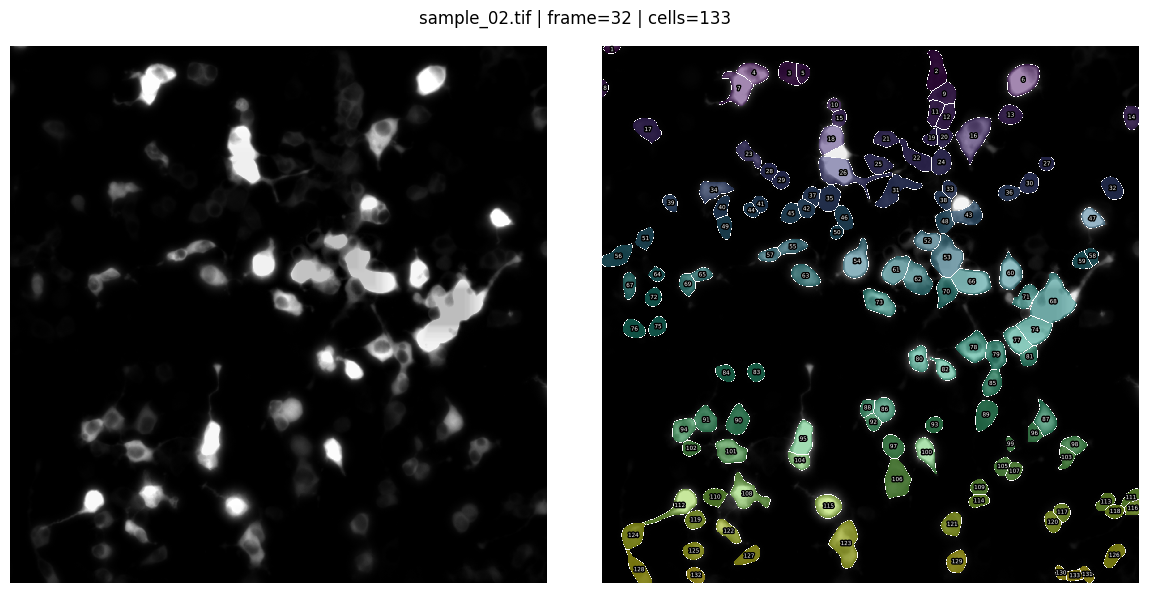

[OK] sample_02.tif | frame=32 | cells=133


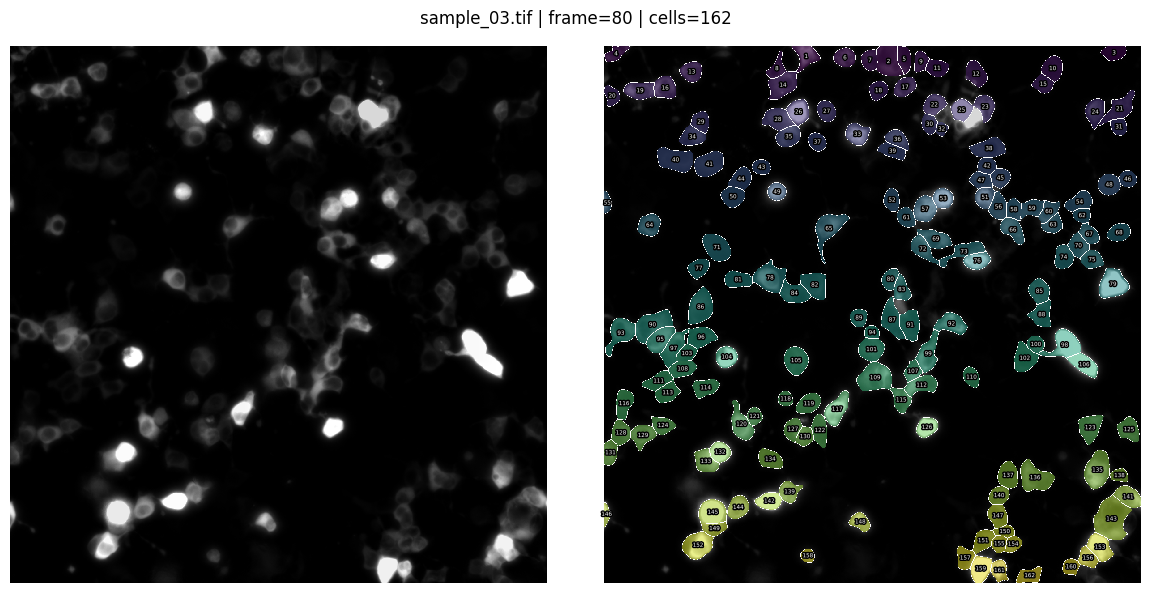

[OK] sample_03.tif | frame=80 | cells=162


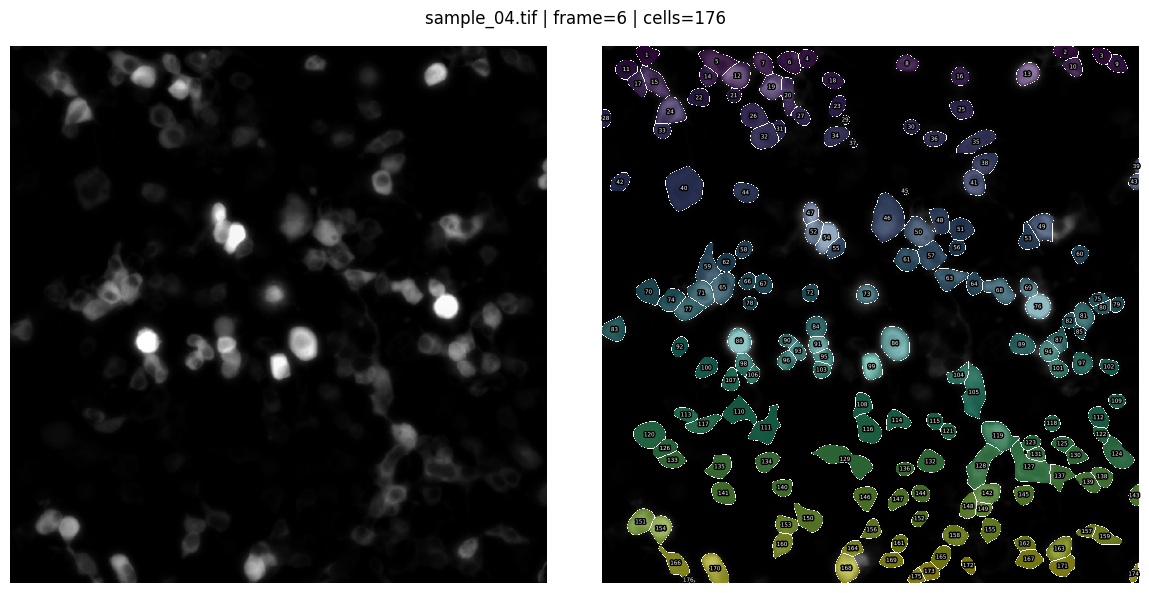

[OK] sample_04.tif | frame=6 | cells=176


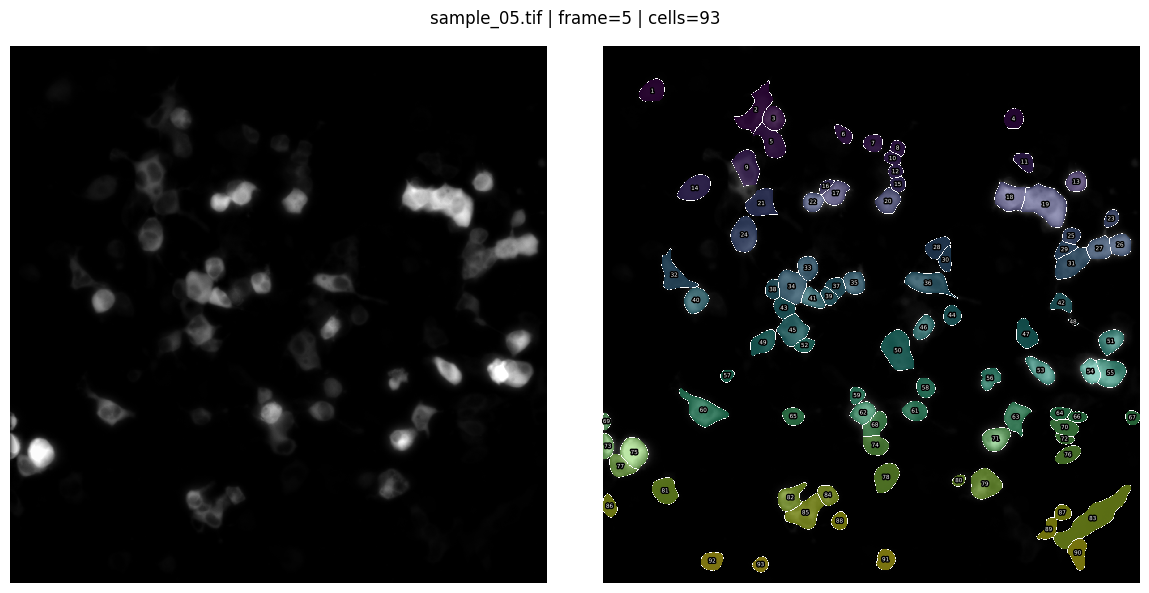

[OK] sample_05.tif | frame=5 | cells=93


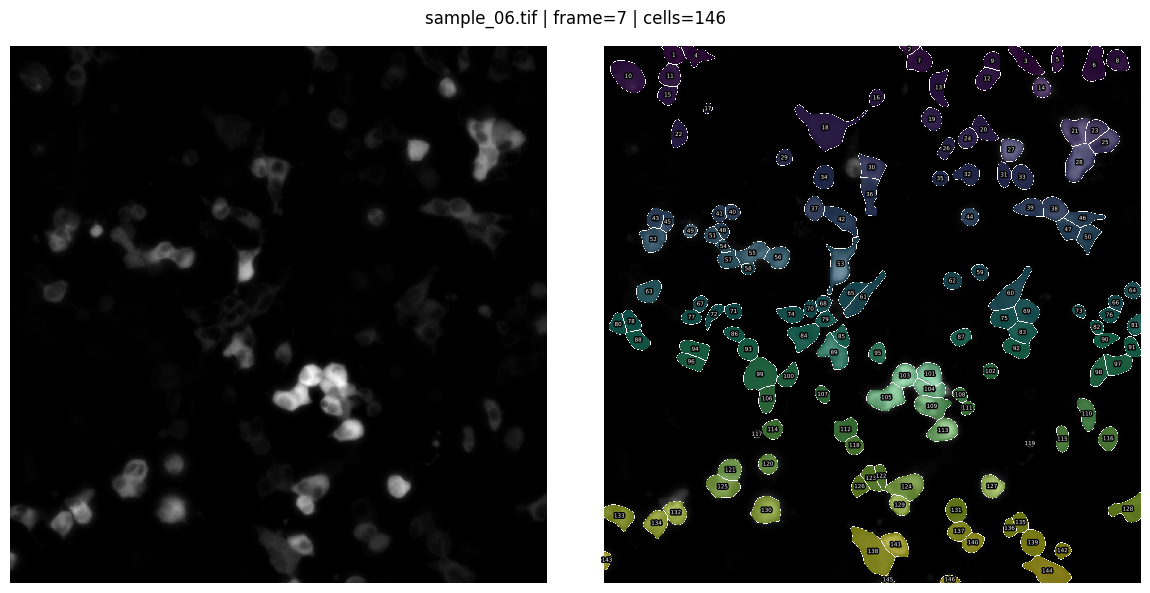

[OK] sample_06.tif | frame=7 | cells=146


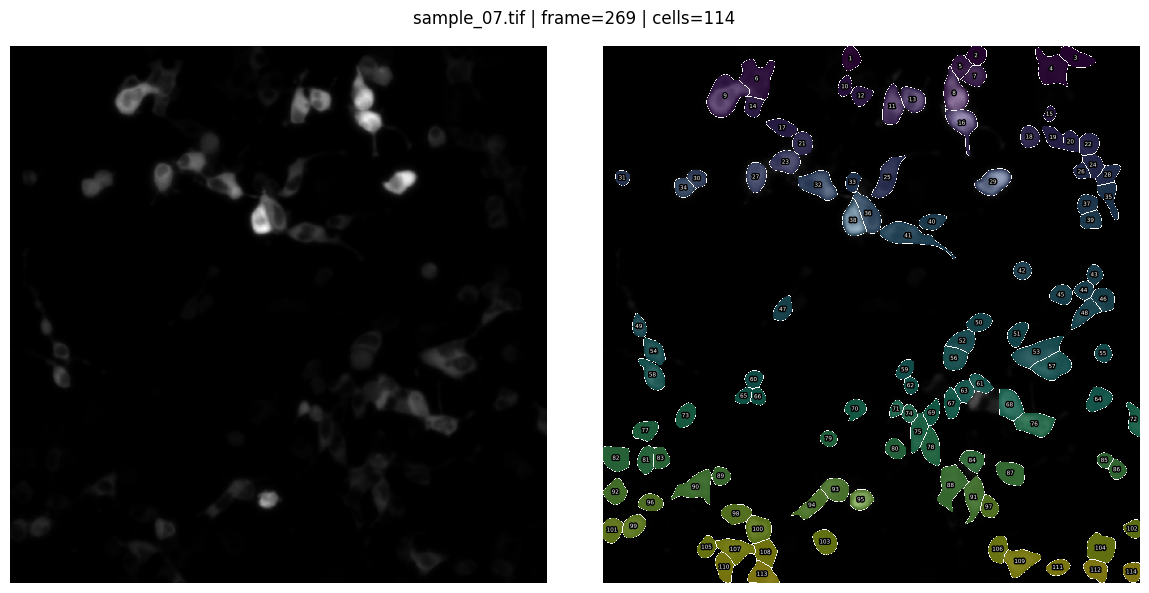

[OK] sample_07.tif | frame=269 | cells=114


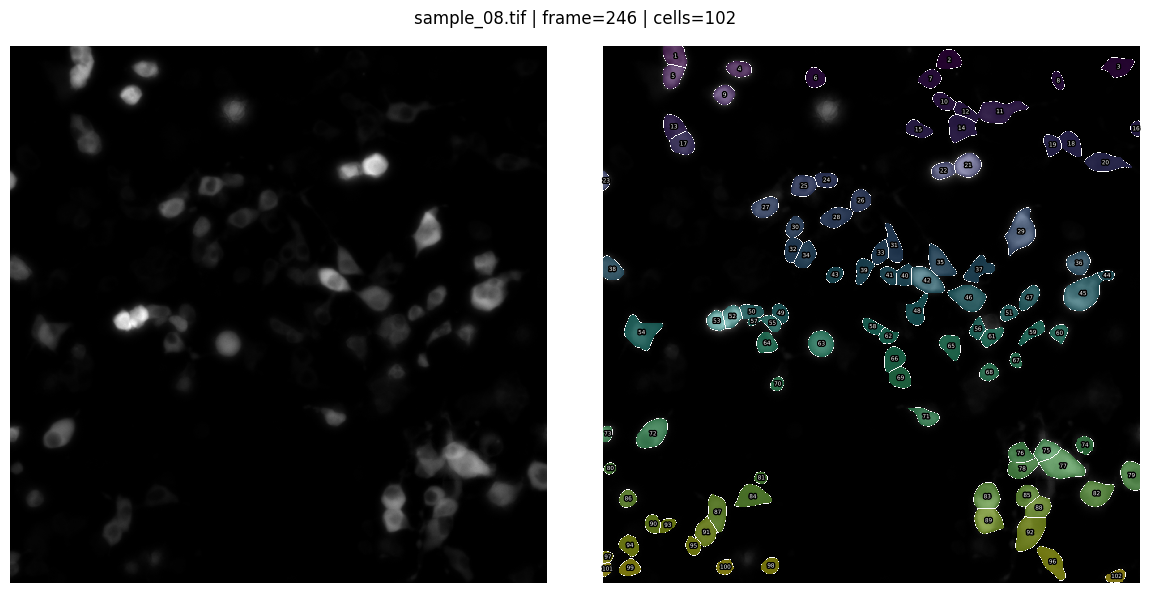

[OK] sample_08.tif | frame=246 | cells=102


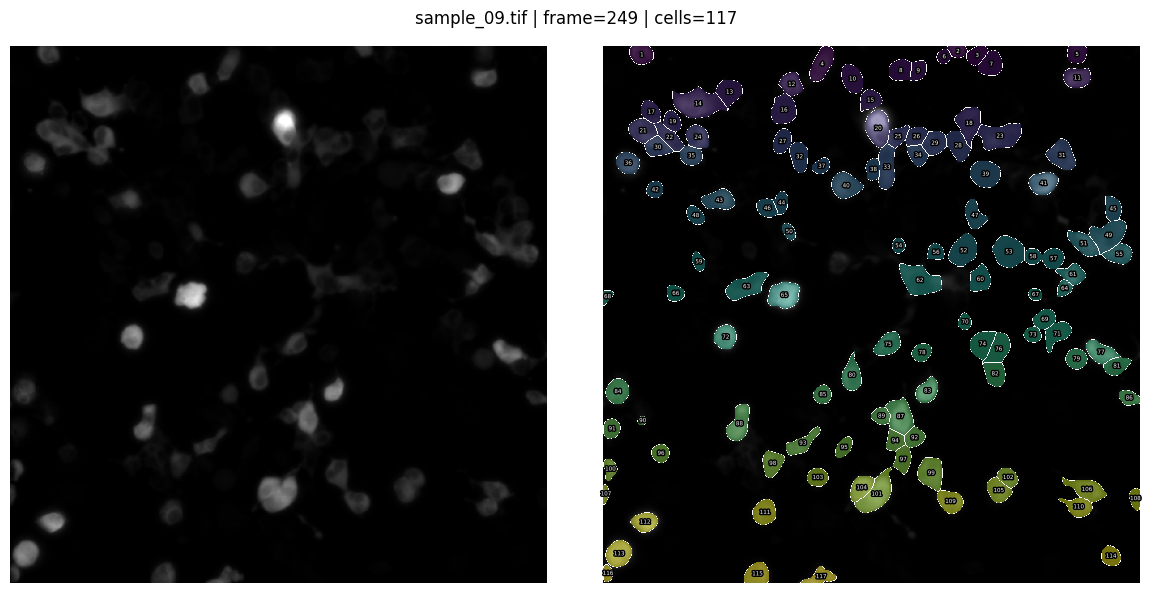

[OK] sample_09.tif | frame=249 | cells=117


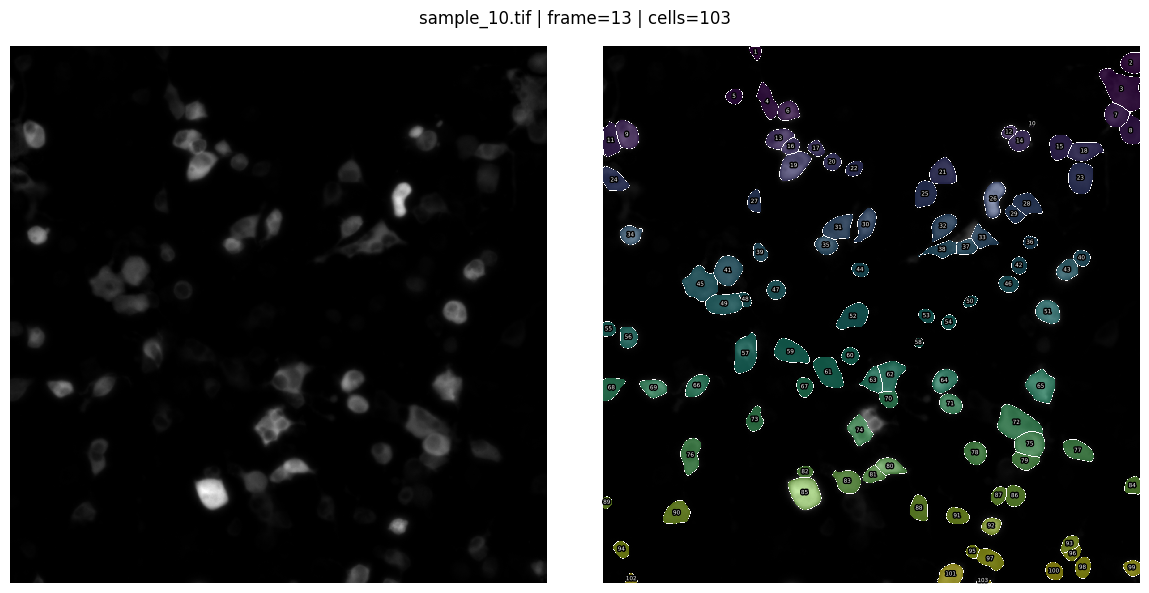

[OK] sample_10.tif | frame=13 | cells=103


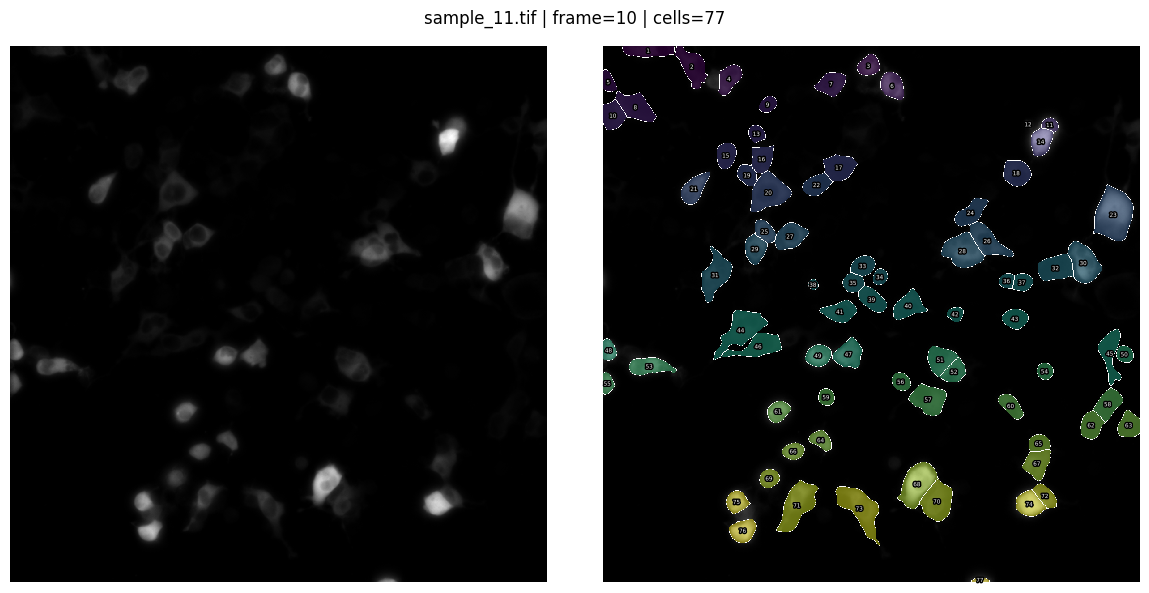

[OK] sample_11.tif | frame=10 | cells=77


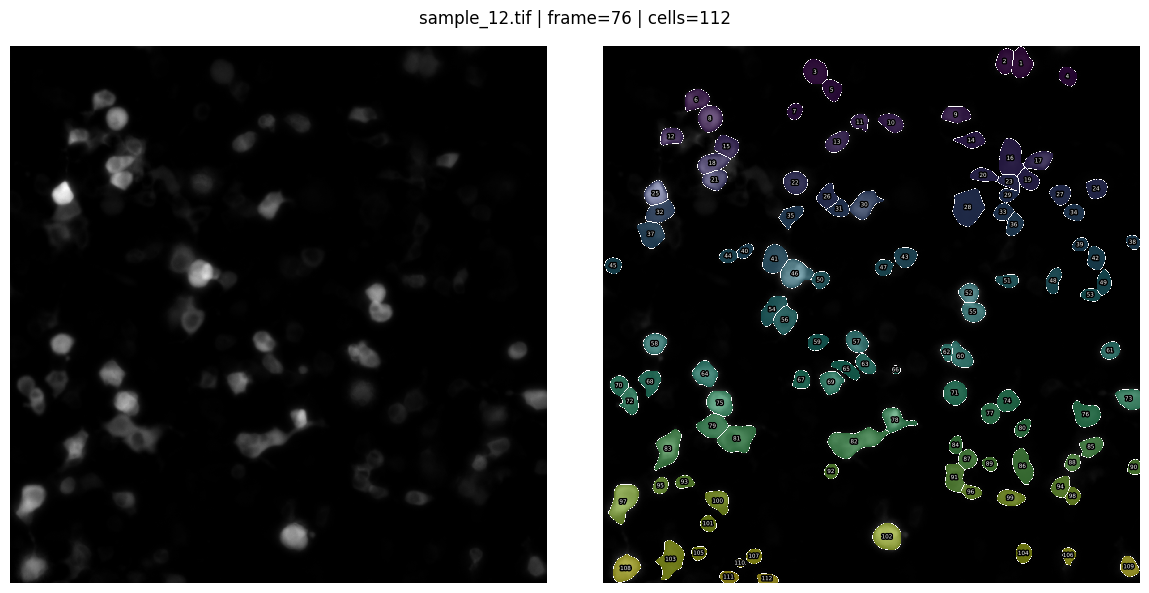

[OK] sample_12.tif | frame=76 | cells=112


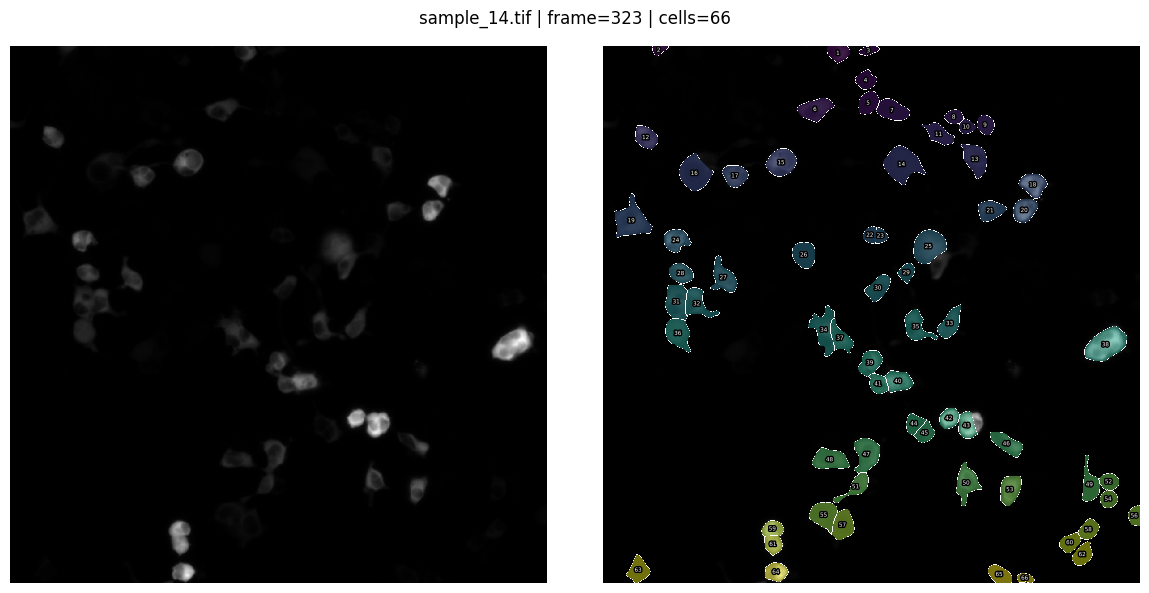

[OK] sample_14.tif | frame=323 | cells=66


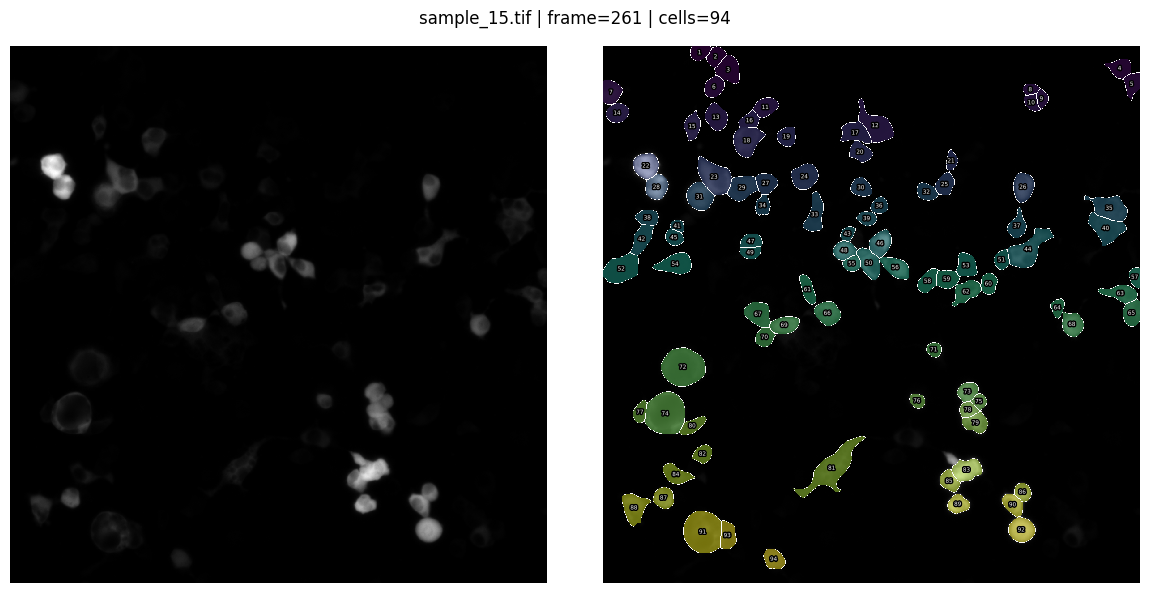

[OK] sample_15.tif | frame=261 | cells=94


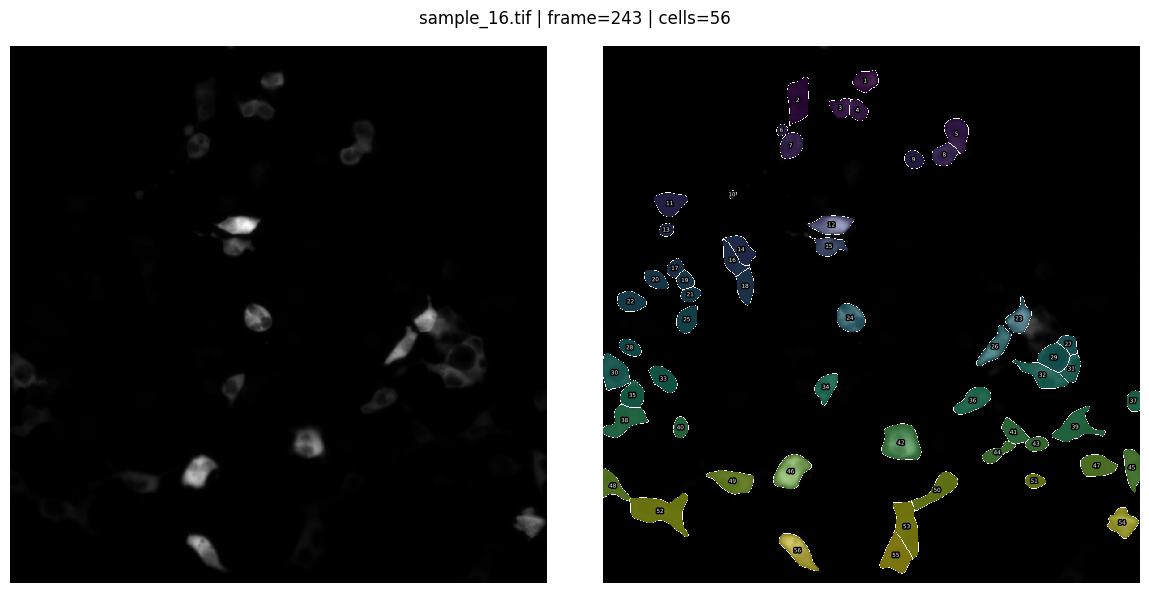

[OK] sample_16.tif | frame=243 | cells=56


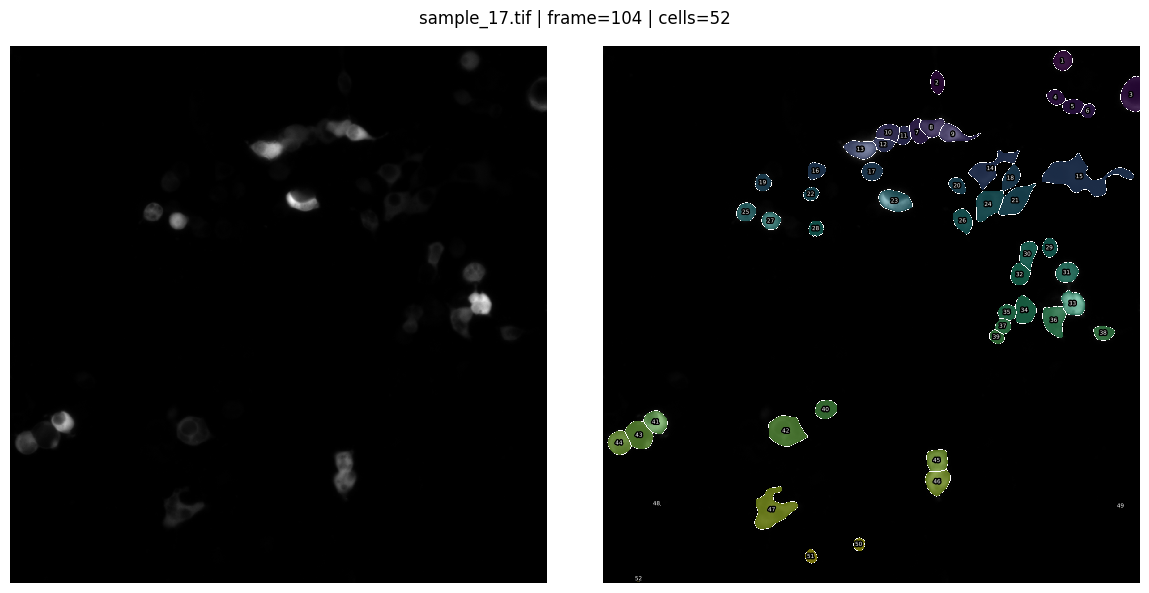

[OK] sample_17.tif | frame=104 | cells=52


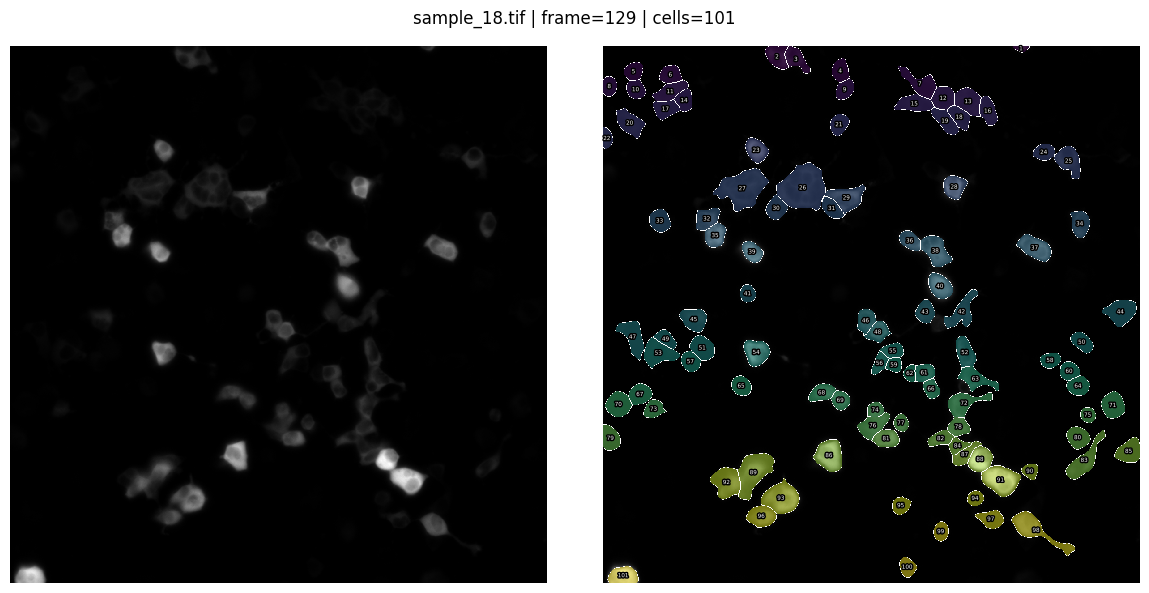

[OK] sample_18.tif | frame=129 | cells=101


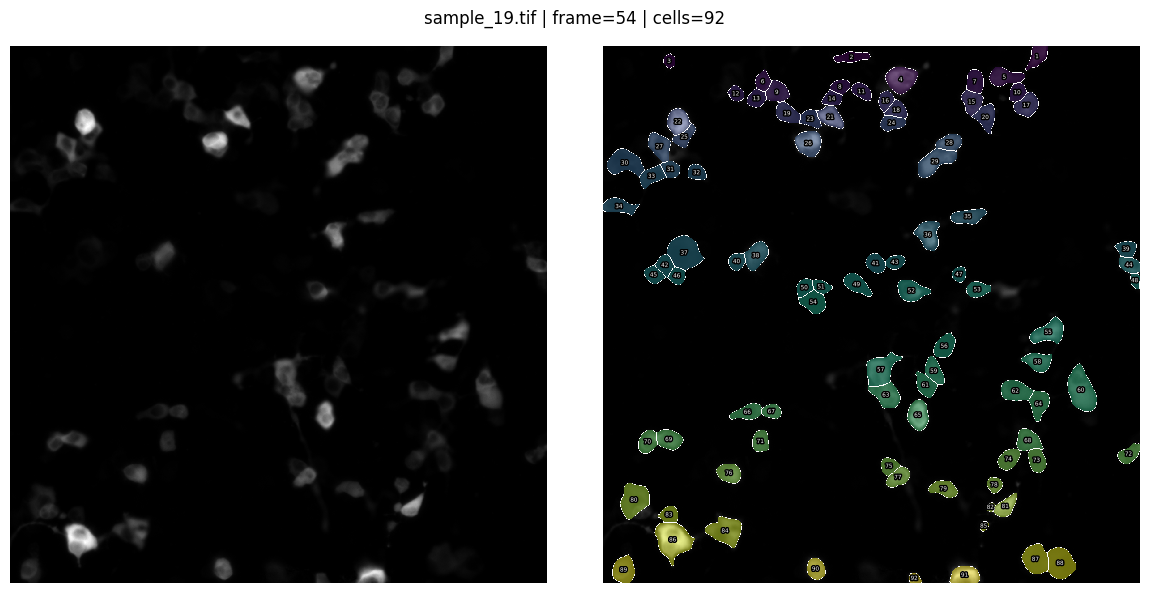

[OK] sample_19.tif | frame=54 | cells=92


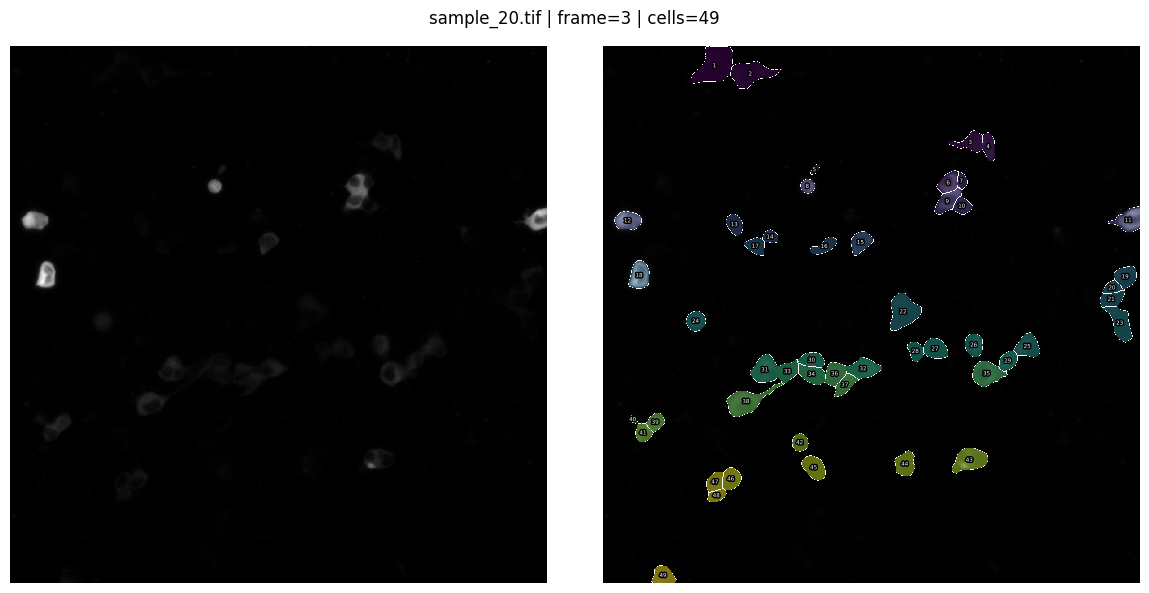

[OK] sample_20.tif | frame=3 | cells=49


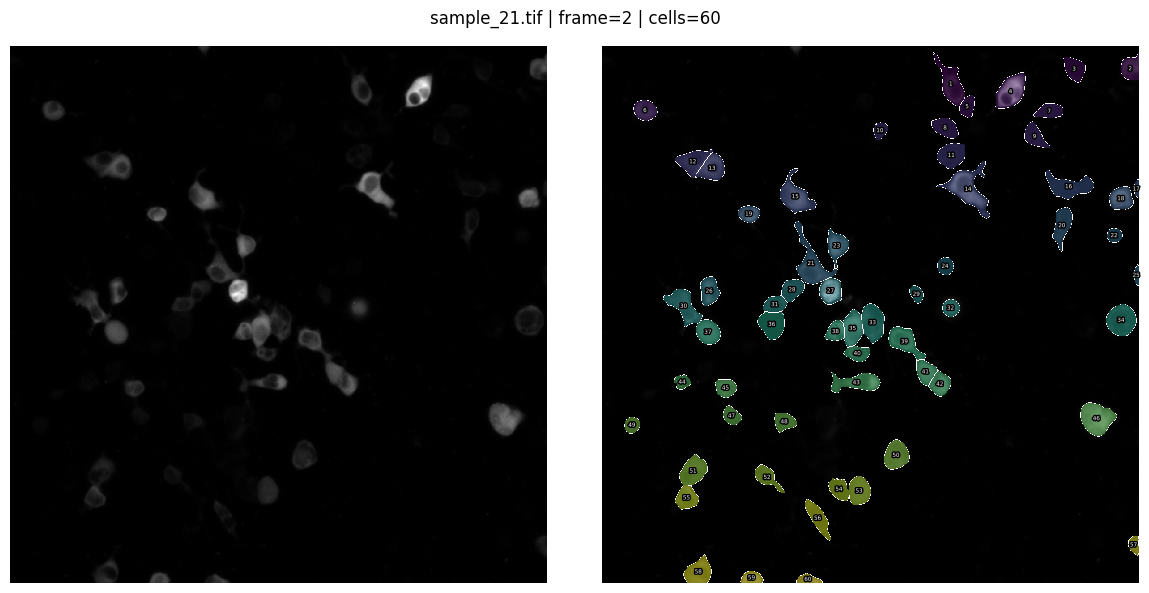

[OK] sample_21.tif | frame=2 | cells=60


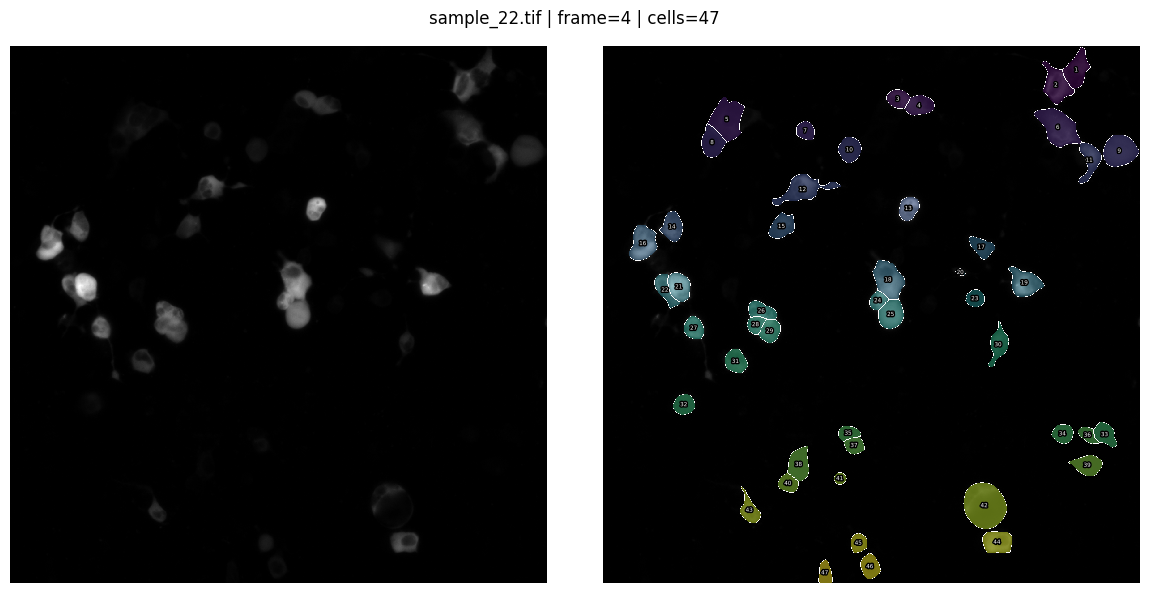

[OK] sample_22.tif | frame=4 | cells=47


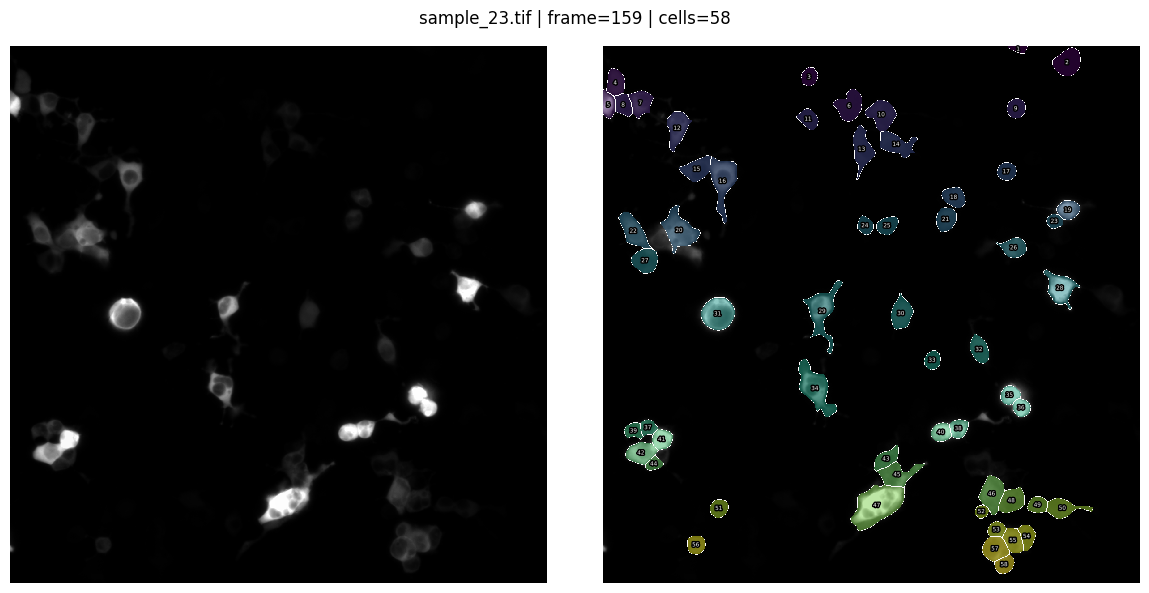

[OK] sample_23.tif | frame=159 | cells=58


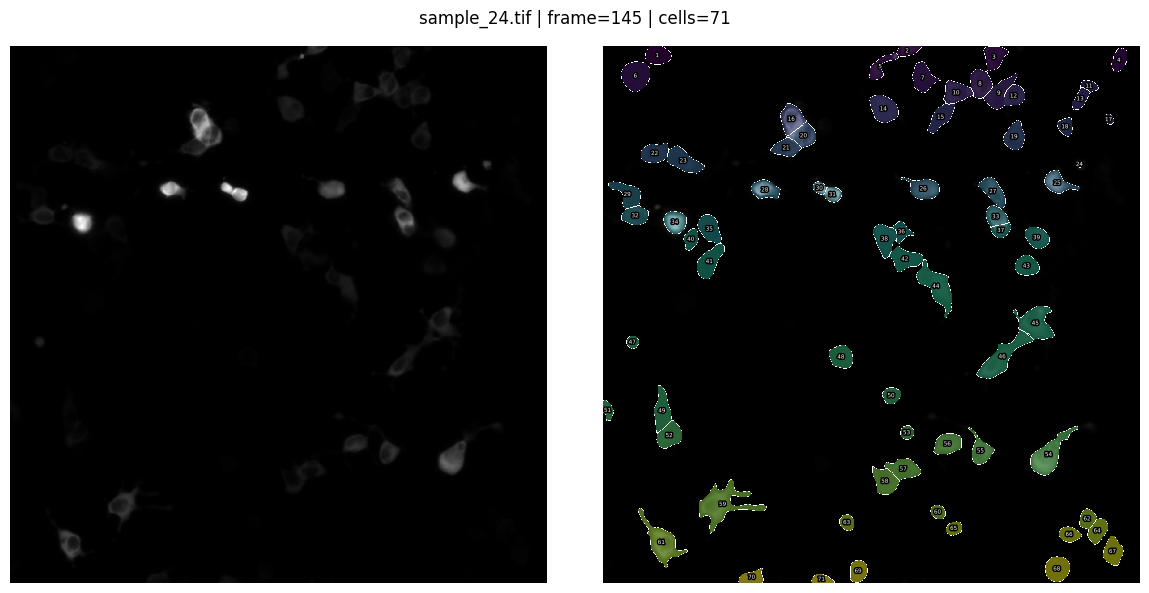

[OK] sample_24.tif | frame=145 | cells=71


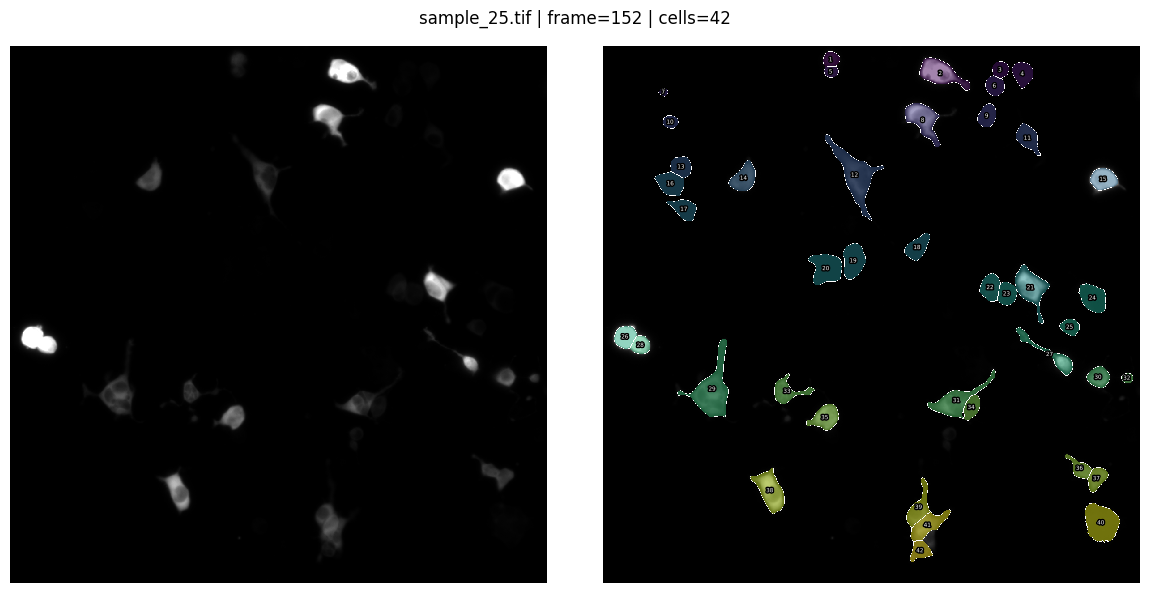

[OK] sample_25.tif | frame=152 | cells=42


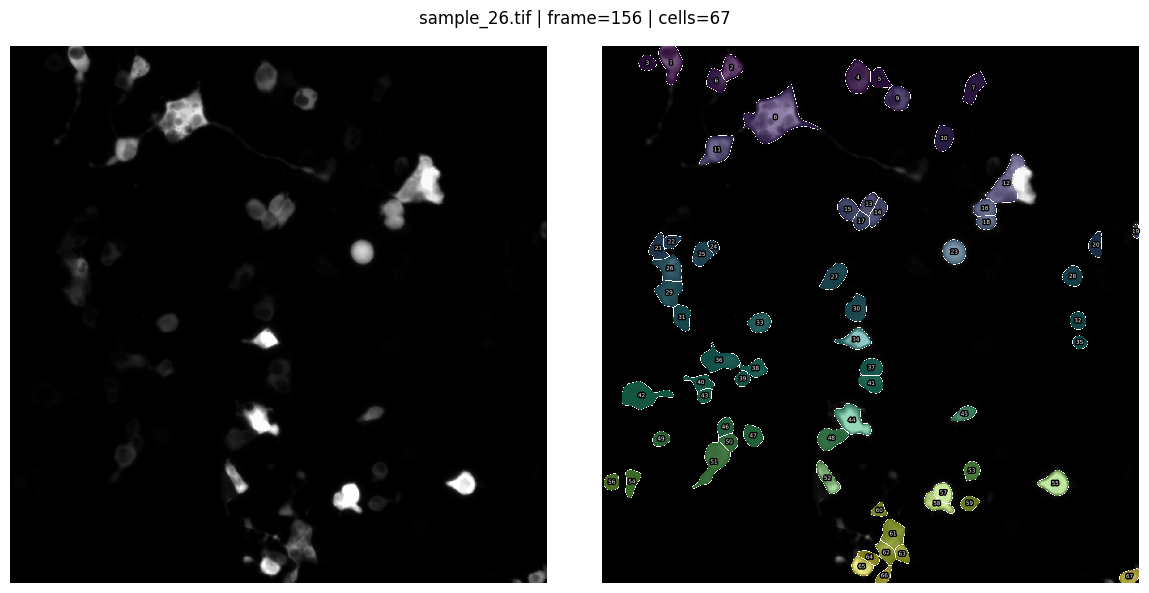

[OK] sample_26.tif | frame=156 | cells=67


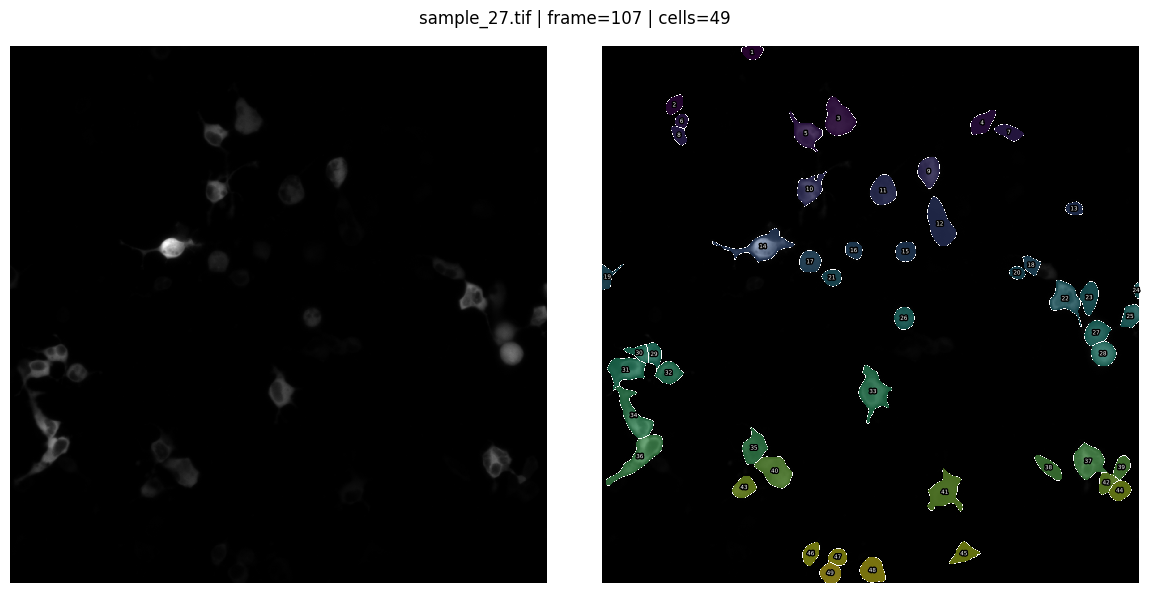

[OK] sample_27.tif | frame=107 | cells=49


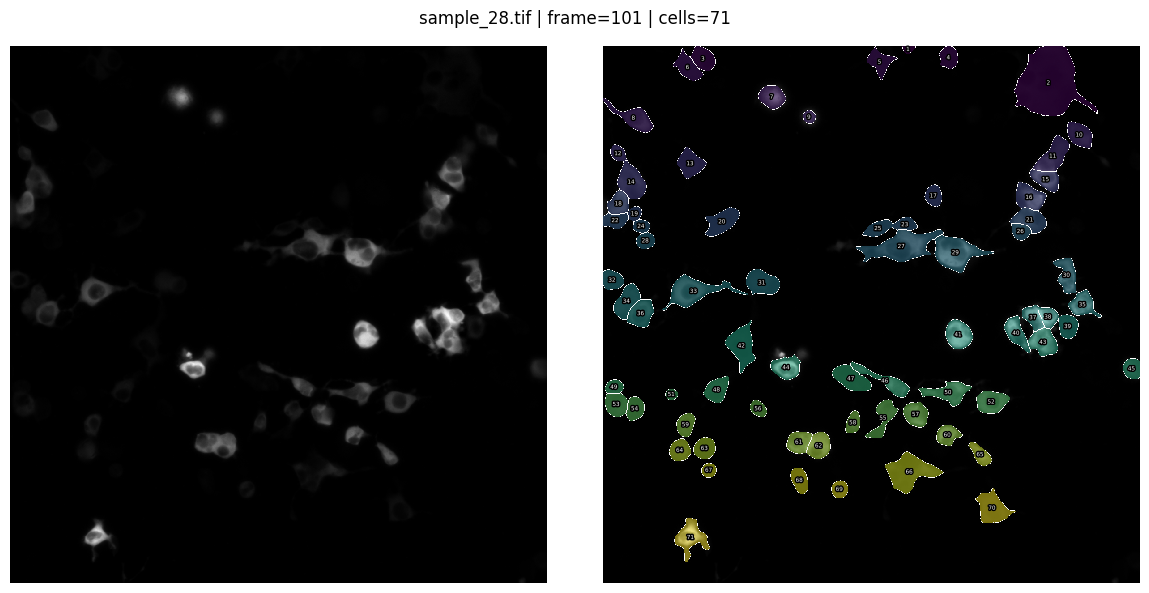

[OK] sample_28.tif | frame=101 | cells=71


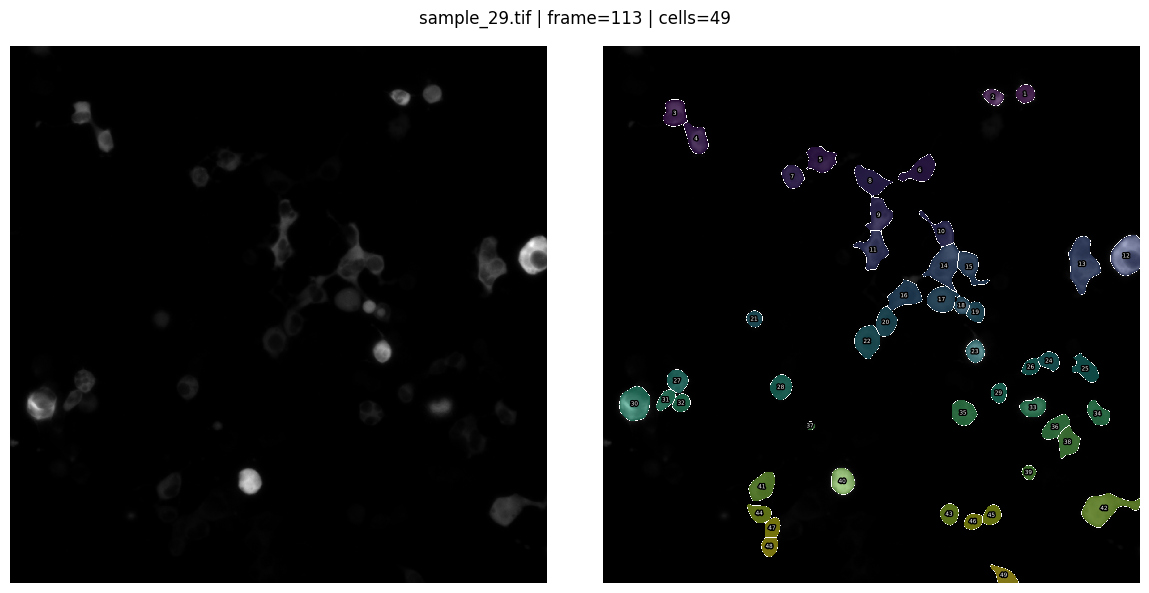

[OK] sample_29.tif | frame=113 | cells=49


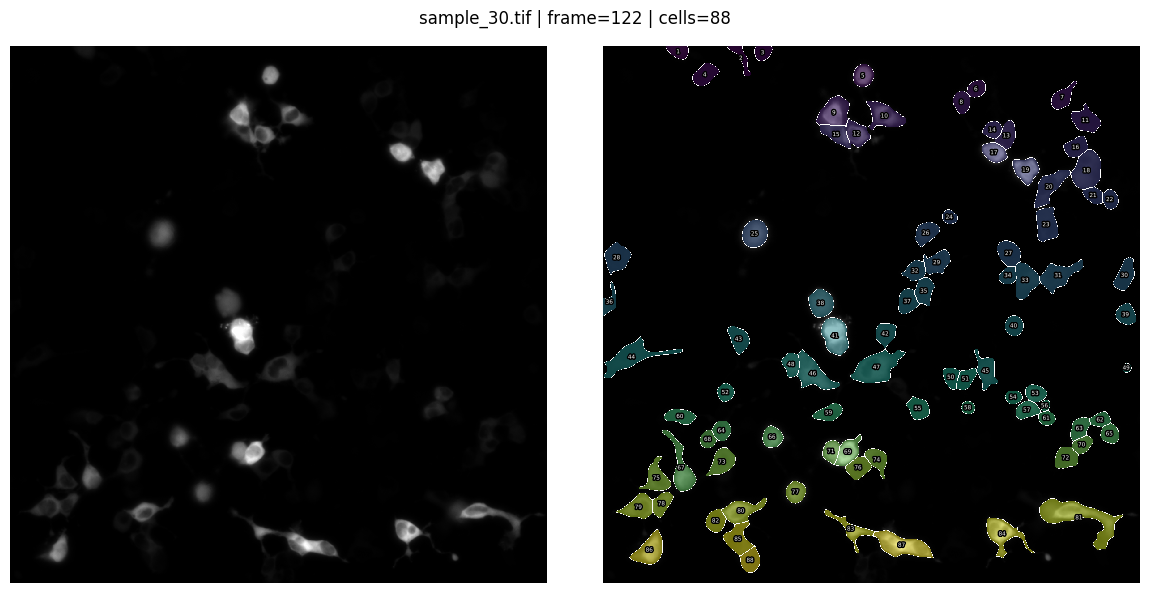

[OK] sample_30.tif | frame=122 | cells=88


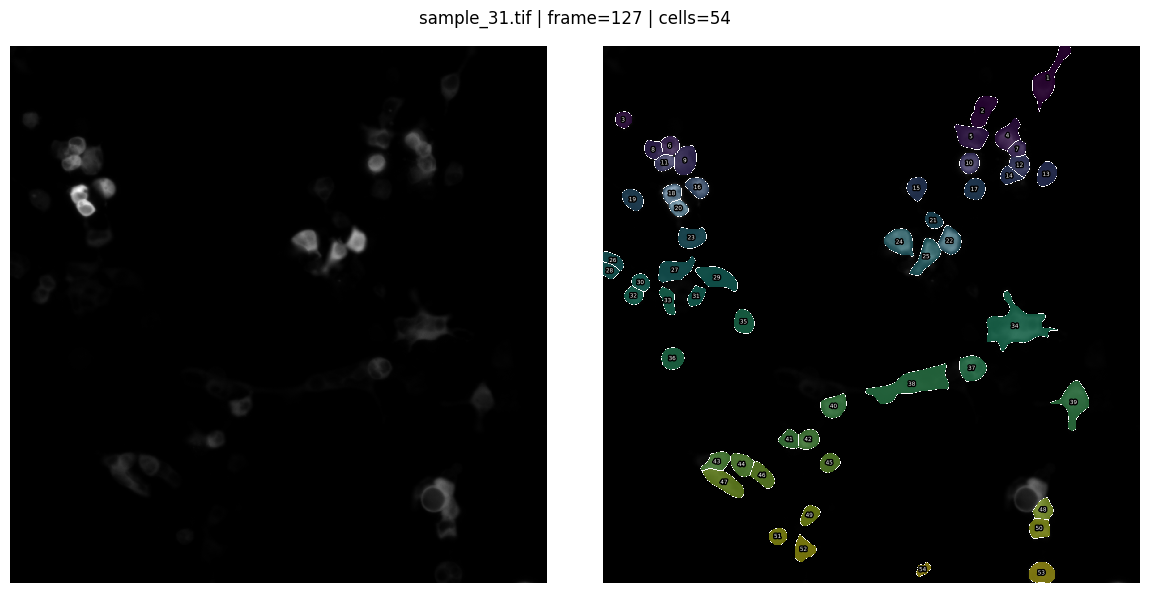

[OK] sample_31.tif | frame=127 | cells=54


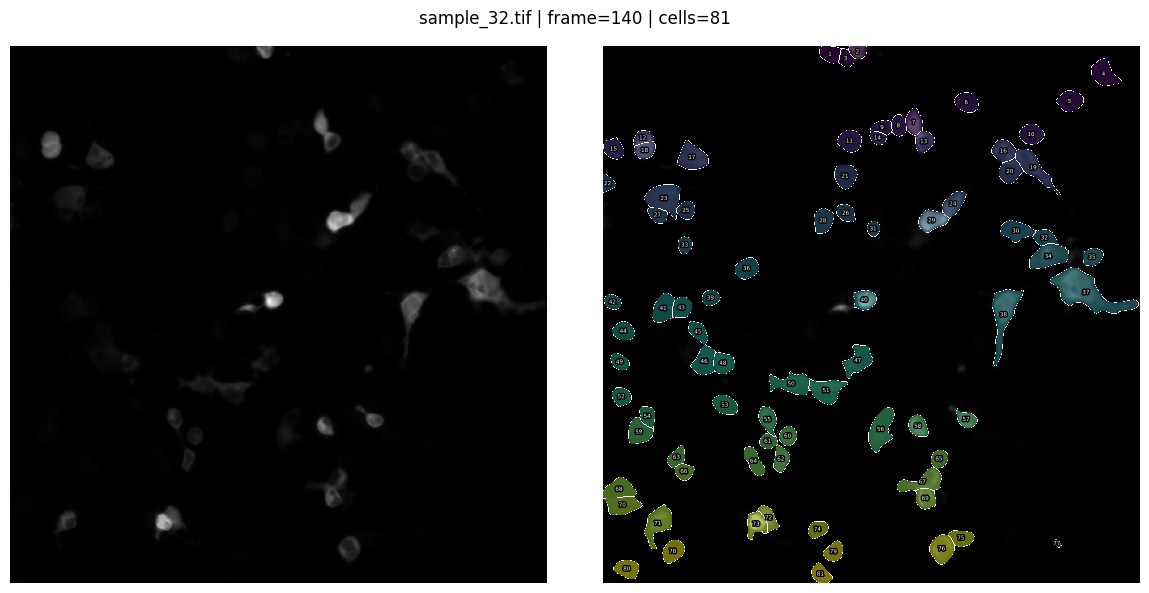

[OK] sample_32.tif | frame=140 | cells=81


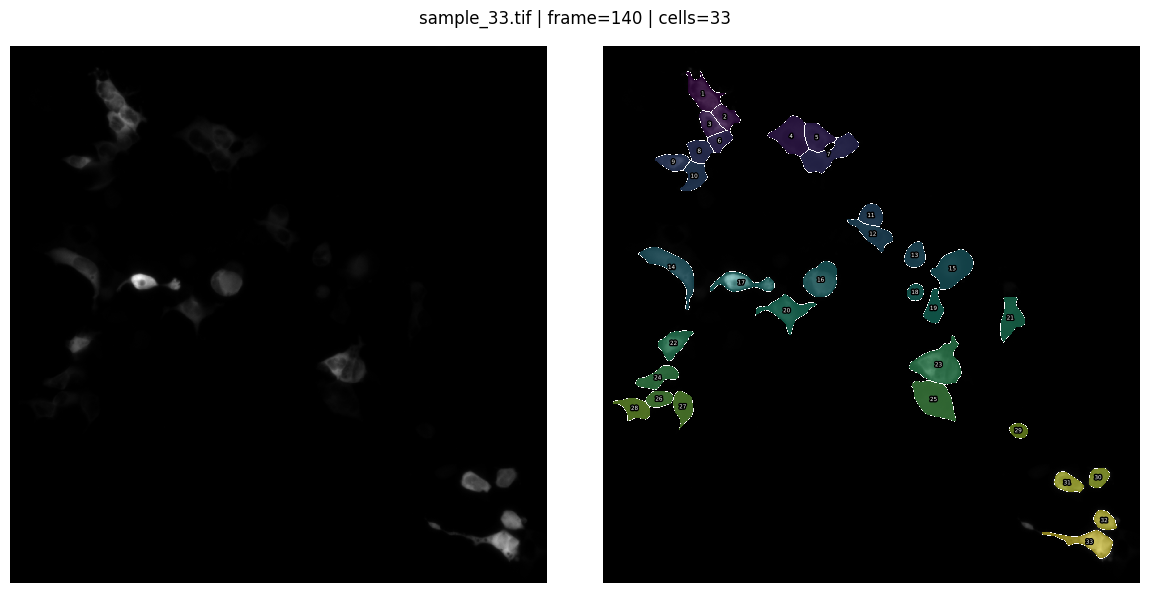

[OK] sample_33.tif | frame=140 | cells=33


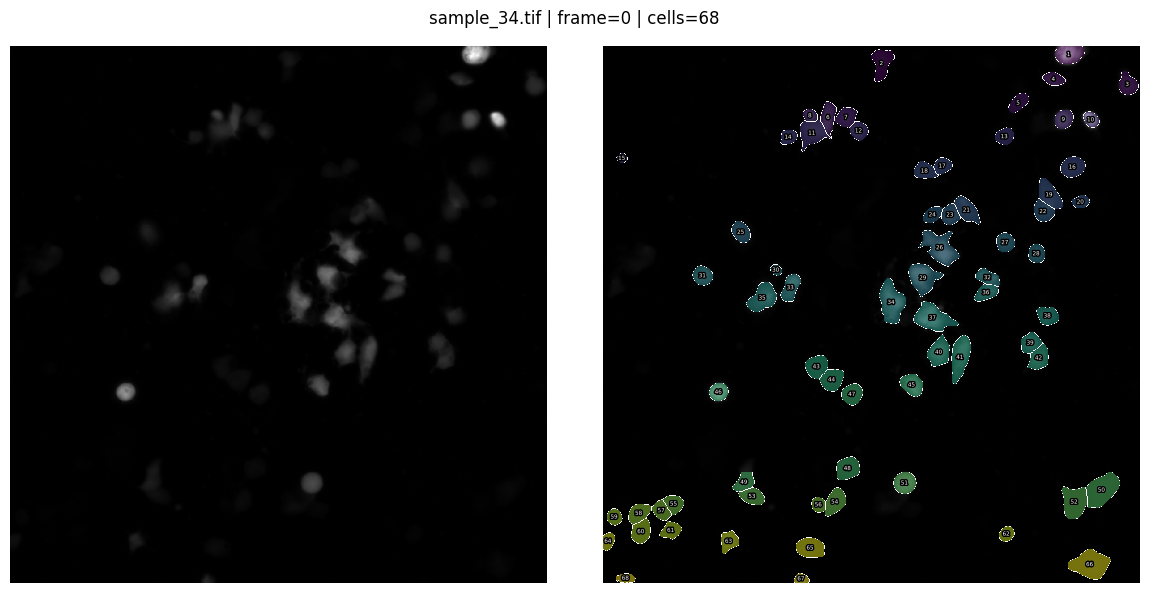

[OK] sample_34.tif | frame=0 | cells=68


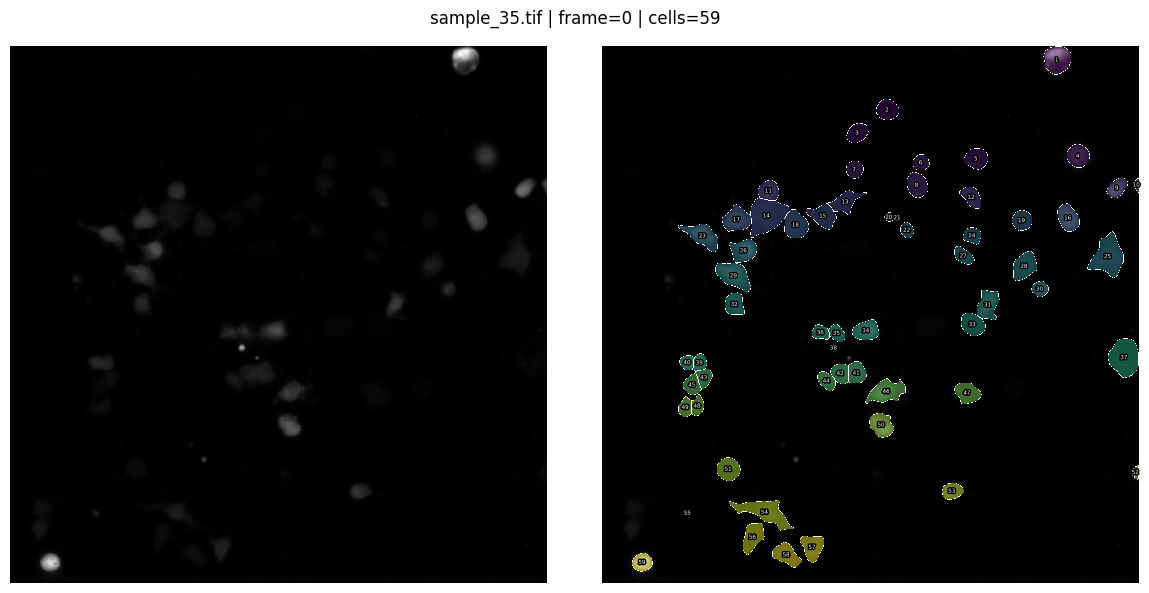

[OK] sample_35.tif | frame=0 | cells=59
saved summary: /content/drive/MyDrive/Colab Notebooks/Cellpose-SAM/overlay/segmentation_summary.csv


In [ ]:
if __name__ == "__main__":
    results = main()